This code is directily simulating the Hamiltonian of raw MS gate with only one mode, followed by two single qubit rotaion $R_{\theta}(\pi/2)$ on both ions. Measuring the $\sigma_{z1}\sigma_{z2}$ as the parity.

In [24]:
import qutip as qt
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import datetime
from numpy import linalg
#from numpy import *
import pandas as pd
from tqdm import tqdm
%matplotlib inline

class MSGateExp:
    def __init__(self, 
                 Nmax = 10, 
                 eta = 0.1,
                 omega_r = np.array([1,1]) * np.pi * 2,
                 omega_b = np.array([1,1]) * np.pi * 2,
                 delta_r = np.array([2,2]) * np.pi * 2,
                 delta_b = np.array([-2,-2]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 tau = 10, # Motional coherence time
                 nth = 0.1,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(10, 0.5)),
                 output = None
                ):
        self.Nmax = Nmax
        self.eta = eta
        self.omega_r = omega_r
        self.omega_b = omega_b
        self.delta_r = delta_r
        self.delta_b = delta_b
        self.phi_r = phi_r
        self.phi_b = phi_b
        self.Gamma = Gamma # Heating rate
        self.tau = tau
        self.nth = nth
        self.s_init = s_init
        self.output = output
    
    def solve(self, t1):
            
        H0 = -1j*self.eta/2 * \
            self.omega_r[0]*np.exp(1j*self.phi_r) * \
            tensor(sigmap(), qeye(2), destroy(self.Nmax))
        def H0_coeff(t, args):
            return np.exp(-1j*self.delta_r[0]*t)
        
        H1 = 1j*self.eta/2 * \
            self.omega_r[0]*np.exp(-1j*self.phi_r) * \
            tensor(sigmam(), qeye(2), create(self.Nmax))
        def H1_coeff(t, args):
            return np.exp(1j*self.delta_r[0]*t)
        
        H2 = -1j*self.eta/2 * \
            self.omega_b[0]*np.exp(1j*self.phi_b) * \
            tensor(sigmap(), qeye(2), create(self.Nmax))
        def H2_coeff(t, args):
            return np.exp(-1j*self.delta_b[0]*t)

        H3 = 1j*self.eta/2 * \
            self.omega_b[0]*np.exp(-1j*self.phi_b) * \
            tensor(sigmam(), qeye(2), destroy(self.Nmax))
        def H3_coeff(t, args):
            return np.exp(1j*self.delta_b[0]*t)

        H4 = -1j*self.eta/2 * \
            self.omega_r[1]*np.exp(1j*self.phi_r) * \
            tensor(qeye(2), sigmap(), destroy(self.Nmax))
        def H4_coeff(t, args):
            return np.exp(-1j*self.delta_r[1]*t)

        H5 = 1j*self.eta/2 * \
            self.omega_r[1]*np.exp(-1j*self.phi_r) * \
            tensor(qeye(2), sigmam(), create(self.Nmax))
        def H5_coeff(t, args):
            return np.exp(1j*self.delta_r[1]*t)

        H6 = -1j*self.eta/2 * \
            self.omega_b[1]*np.exp(1j*self.phi_b) * \
            tensor(qeye(2), sigmap(), create(self.Nmax))
        def H6_coeff(t, args):
            return np.exp(-1j*self.delta_b[1]*t)

        H7 = 1j*self.eta/2 * \
            self.omega_b[1]*np.exp(-1j*self.phi_b) * \
            tensor(qeye(2), sigmam(), destroy(self.Nmax))
        def H7_coeff(t, args):
            return np.exp(1j*self.delta_b[1]*t)
        
        H = [[H0, H0_coeff], [H1, H1_coeff], [H2, H2_coeff], [H3, H3_coeff],
             [H4, H4_coeff], [H5, H5_coeff], [H6, H6_coeff], [H7, H7_coeff]]
        
        Heye = tensor(qeye(2), qeye(2), qeye(self.Nmax))
        
        c_ops = [tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*destroy(self.Nmax)),
                 tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*create(self.Nmax))]
        
        if self.tau != 0:
            c_ops.append(tensor(qeye(2), qeye(2), np.sqrt(2/self.tau)*create(self.Nmax)*destroy(self.Nmax)))
        
        self.output = mesolve(H, self.s_init, t1, c_ops, [])
        
    def time_scan(self,
                 t_start,
                 t_stop,
                 Nsample,
                  isPlot = True
                 ):
        now = datetime.datetime.now()
        t_list = np.linspace(t_start, t_stop, Nsample)
        self.solve(t_list)
        self.measure(self.output.states, t_list, isPlot)
        now2 = datetime.datetime.now()
        #print(now2-now)
        return self.output.states
        
    
    def StarkShift_scan(self,
                 t_start,
                 t_stop,
                 Nsample,
                 StarkShiftScanList,
                       ):
        
        now = datetime.datetime.now()
        t_list = np.linspace(t_start, t_stop, Nsample)
        ScanResult_ee = []
        ScanResult_gg = []
        
        s_ee = tensor(fock(2, 0), fock(2, 0))
        s_gg = tensor(fock(2, 1), fock(2, 1))
        def _measure(state, s_meas):
            state_ptr = state.ptrace([0,1])  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
            
        for ss in StarkShiftScanList:
            self.delta_r = delta_r + ss
            self.delta_b = delta_b + ss
            
            self.solve(t_list)
            self.measure(self.output.states, t_list)
            ee = _measure(self.output.states[-1], s_ee)
            gg = _measure(self.output.states[-1], s_gg)
            ScanResult_ee.append(ee)
            ScanResult_gg.append(gg)
        now2 = datetime.datetime.now()
        print(now2-now)
        
        plt.plot(StarkShiftScanList, ScanResult_ee, label = '11')
        plt.plot(StarkShiftScanList, ScanResult_gg, label = '00')
        plt.xlabel('Stark Shift scan')
        plt.ylabel('Probability')
        plt.legend()
        
    def detuning_scan(self,
                      delta_start,
                      delta_stop,
                      Nsample,
                      t1=np.linspace(0, 0.5, 2),
                      t2=np.linspace(0, 0.5, 2),
                     ):
        delta_list = np.linspace(delta_start, delta_stop, Nsample)
        states = []
        for delta in delta_list:
            self.delta_r = delta*np.array([1, 1])*np.pi*2
            self.delta_b = delta*np.array([-1, -1])*np.pi*2
            self.s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(self.Nmax, 0.5))
            self.solve(t1)
            states.append(self.output.states[-1])
        #states = np.array(states)
        self.measure(states, delta_list)
        
    def parity_scan(self,
                    t_gate,
                    phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = 0,
                    omega2 = 0,
                    t_rotation = 0,
                    deltaPhi = 0
                 ):
        output_states = self.time_scan(0, t_gate, 101, isPlot = False)
        
        
        tlist = np.linspace(0, t_rotation, 101)
        c_ops = [tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*destroy(self.Nmax)),
                 tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*create(self.Nmax))]
        s_init = output_states[-1]
        parity = [] 
        for phi in phi_list:
            sigma_phi = np.cos(phi)*sigmax() - np.sin(phi)*sigmay()
            sigma_phi_2 = np.cos(phi+deltaPhi)*sigmax() - np.sin(phi+deltaPhi)*sigmay()
            H1 = omega1*tensor(sigma_phi, qeye(2), qeye(self.Nmax))
            H2 = omega2*tensor(qeye(2), sigma_phi_2, qeye(self.Nmax))
            H = H1+H2
            self.output = mesolve(H, s_init, tlist, c_ops, [])
            szz = (self.output.states[-1].ptrace([0,1])*tensor(sigmaz(),sigmaz())).tr() 
            parity.append(szz)
        plt.plot(phi_list, parity)
        plt.xlabel('Phase')
        plt.ylabel('Parity')
        plt.ylim([-1.001,1.001])
        plt.show()
        contrast = max(parity)-min(parity)
        return s_init, contrast
        
    def parity_scan_repeatable(self,
                    t_gate,
                    phi,
                    omega1 = 0,
                    omega2 = 0,
                    t_rotation = 0,
                    deltaPhi = 0
                 ):
        output_states = self.time_scan(0, t_gate, 2, isPlot = False)
        
        
        tlist = np.linspace(0, t_rotation, 101)
        c_ops = [tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*destroy(self.Nmax)),
                 tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*create(self.Nmax))]
        s_init = output_states[-1]
        
        sigma_phi = np.cos(phi)*sigmax() - np.sin(phi)*sigmay()
        sigma_phi_2 = np.cos(phi+deltaPhi)*sigmax() - np.sin(phi+deltaPhi)*sigmay()
        H1 = omega1*tensor(sigma_phi, qeye(2), qeye(self.Nmax))
        H2 = omega2*tensor(qeye(2), sigma_phi_2, qeye(self.Nmax))
        H = H1+H2
        self.output = mesolve(H, s_init, tlist, c_ops, [])
        szz = (self.output.states[-1].ptrace([0,1])*tensor(sigmaz(),sigmaz())).tr() 
        return szz
        
        
    def measure(self, states, x_axis, isPlot = True):
        # states: np.array of dm includes two ions and phonons
        s_ee = tensor(fock(2, 0), fock(2, 0))
        s_gg = tensor(fock(2, 1), fock(2, 1))
        s_eg = (tensor(fock(2, 0), fock(2, 1)) +
                tensor(fock(2, 1), fock(2, 0))).unit()
        
        def _measure(state, s_meas):
            state_ptr = state.ptrace([0,1])  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
         
        ee = np.zeros(len(states))
        gg = np.zeros(len(states))
        eg = np.zeros(len(states))
        for i in range(len(states)):
            ee[i] = _measure(states[i], s_ee)
            gg[i] = _measure(states[i], s_gg)
            eg[i] = _measure(states[i], s_eg)
        if isPlot:
            fig, ax = plt.subplots()
            ax.plot(x_axis, ee)
            ax.plot(x_axis, gg)
            ax.plot(x_axis, eg)
            # ax.set_xlabel()
            ax.set_ylabel('Probability')
            ax.legend(('11', '00', '01+10'))
            plt.show()
       

t_gate = 250.0us


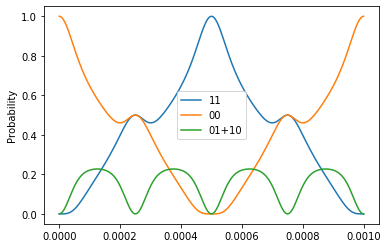

In [39]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10
exp1 = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 tau = 10,
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)
states = exp1.time_scan(0, 4*tg, 200)

## Idea case:

t_gate = 250.0us


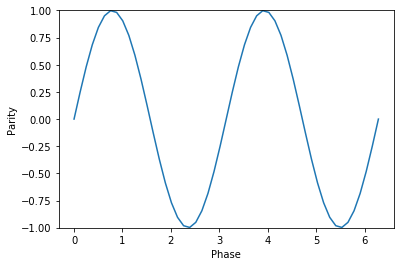

0.9988095891838646

In [50]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10
exp2 = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 tau = 1,
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)
t_Raman = 6e-6 # pi time
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega
szz,contrast = exp2.parity_scan(t_gate = tg,
                    phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = omega1,
                    omega2 = omega2,
                    t_rotation = t_Raman/2 # pi/2 rotation
                         )
state_ptr = szz.ptrace([0,1])
s_eg = (tensor(fock(2, 0), fock(2, 1)) +
                tensor(fock(2, 1), fock(2, 0))).unit()
odd = s_eg.dag()*state_ptr*s_eg   
if odd.data.data.size:
    P_odd = np.real(odd.data.data[0])
else:
    P_odd = 0.0    # np.array has same type
fidelity = (contrast/2+(1-P_odd))/2
fidelity

In [130]:
from tqdm import tqdm
from scipy.optimize import curve_fit

def linear( x, a, b ):
    return a * x +b
def FitLinear(xdata, ydata, guess):
    popt, pcov = curve_fit(linear, xdata, ydata, guess)
    plt.plot(xdata, linear(xdata, *popt), 'r-')
    plt.plot(xdata, ydata, ls='',marker='o')
#     plt.legend()
    plt.xlabel('log_10(1/Coherence time)')
    plt.ylabel('log_10(Fidelity)')
    plt.show()
    print(popt)
    print(np.sqrt(np.diag(pcov)[0]))
    return popt, np.sqrt(np.diag(pcov)[0])

  0%|          | 0/21 [00:00<?, ?it/s]

tau =  0.001


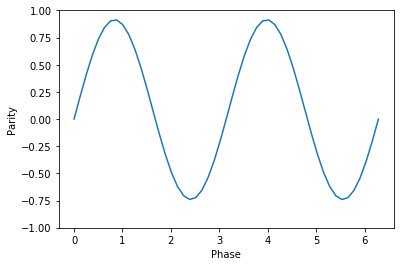

  5%|▍         | 1/21 [00:01<00:27,  1.37s/it]

tau =  0.0012589254117941675


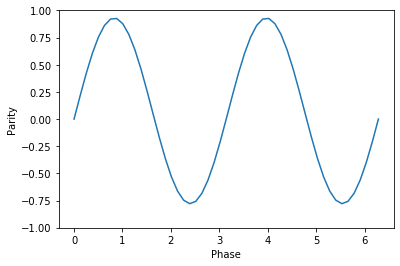

 10%|▉         | 2/21 [00:02<00:26,  1.37s/it]

tau =  0.001584893192461114


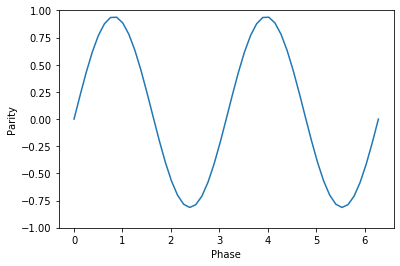

 14%|█▍        | 3/21 [00:04<00:24,  1.36s/it]

tau =  0.001995262314968879


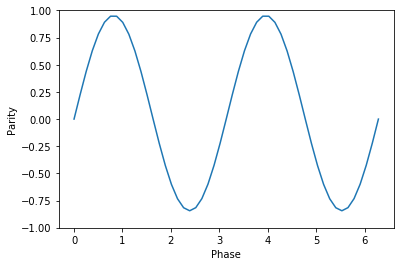

 19%|█▉        | 4/21 [00:05<00:22,  1.32s/it]

tau =  0.0025118864315095794


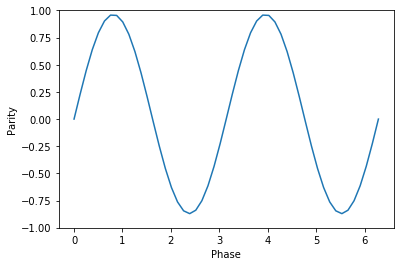

 24%|██▍       | 5/21 [00:06<00:20,  1.29s/it]

tau =  0.0031622776601683794


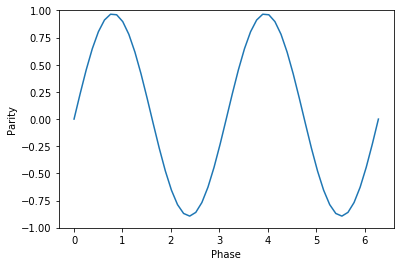

 29%|██▊       | 6/21 [00:07<00:18,  1.27s/it]

tau =  0.003981071705534973


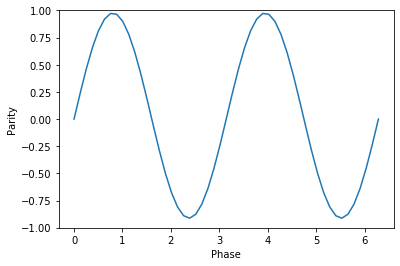

 33%|███▎      | 7/21 [00:08<00:17,  1.25s/it]

tau =  0.005011872336272725


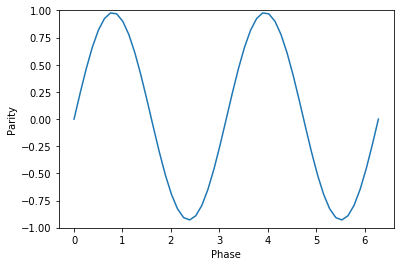

 38%|███▊      | 8/21 [00:10<00:16,  1.24s/it]

tau =  0.00630957344480193


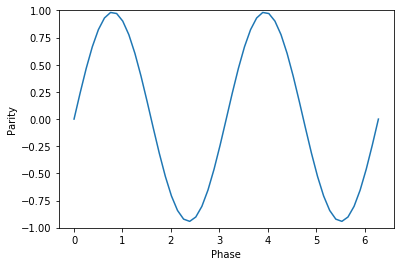

 43%|████▎     | 9/21 [00:11<00:15,  1.27s/it]

tau =  0.007943282347242814


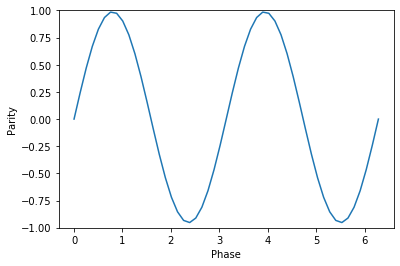

 48%|████▊     | 10/21 [00:12<00:14,  1.28s/it]

tau =  0.01


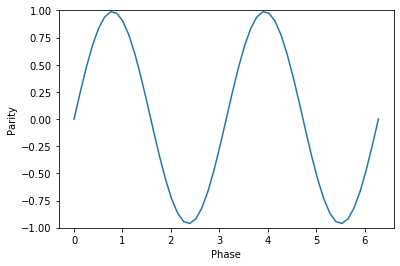

 52%|█████▏    | 11/21 [00:14<00:12,  1.28s/it]

tau =  0.012589254117941675


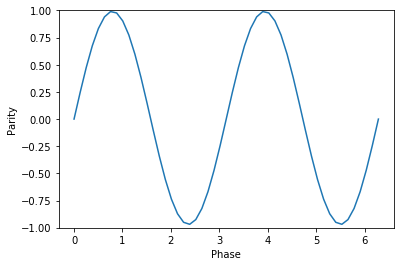

 57%|█████▋    | 12/21 [00:15<00:11,  1.29s/it]

tau =  0.01584893192461114


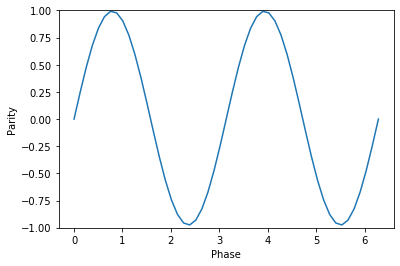

 62%|██████▏   | 13/21 [00:16<00:10,  1.28s/it]

tau =  0.0199526231496888


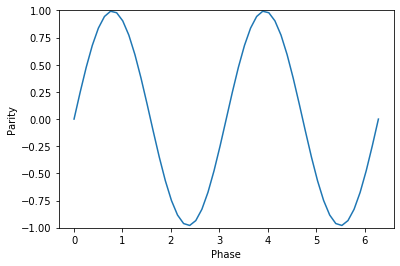

 67%|██████▋   | 14/21 [00:17<00:08,  1.26s/it]

tau =  0.025118864315095808


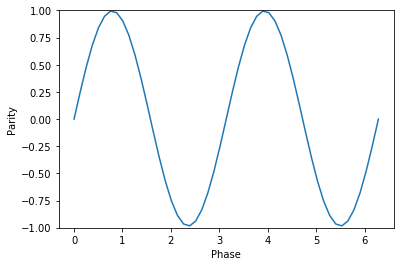

 71%|███████▏  | 15/21 [00:19<00:07,  1.29s/it]

tau =  0.03162277660168379


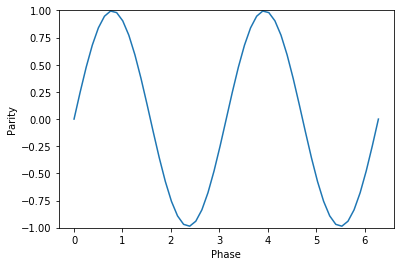

 76%|███████▌  | 16/21 [00:20<00:06,  1.31s/it]

tau =  0.039810717055349734


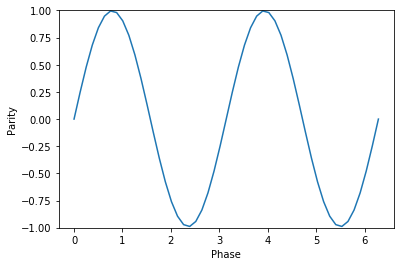

 81%|████████  | 17/21 [00:21<00:05,  1.31s/it]

tau =  0.05011872336272725


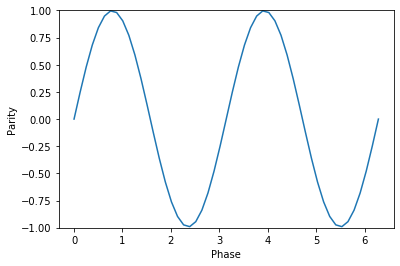

 86%|████████▌ | 18/21 [00:23<00:03,  1.30s/it]

tau =  0.06309573444801933


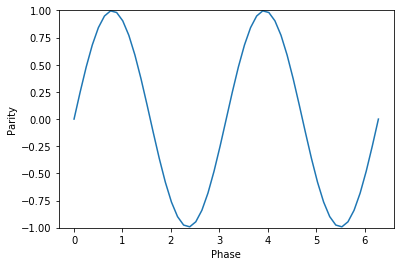

 90%|█████████ | 19/21 [00:24<00:02,  1.39s/it]

tau =  0.07943282347242818


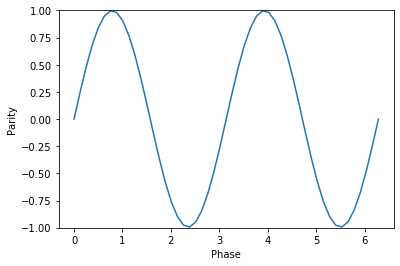

 95%|█████████▌| 20/21 [00:26<00:01,  1.39s/it]

tau =  0.1


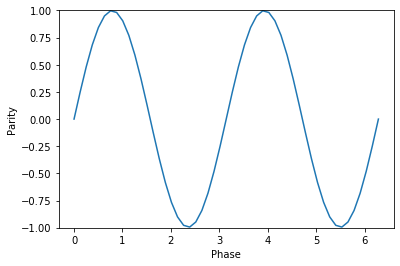

100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


In [115]:
tau_list = np.logspace(-3, -1, 21)
infidelities = []
for tau in tqdm(tau_list):
    omega = 2e4
    eta = 0.1
    delta = 2*eta*omega
    tg = 1/delta # pi/2 gate time
#     print('t_gate = '+str(tg*1e6)+'us')
    nth = 0.1
    Nmax = 10

    print('tau = ', tau)
    exp2 = MSGateExp(Nmax=Nmax,eta = eta,
                     omega_r = np.array([omega,omega]) * np.pi * 2,
                     omega_b = np.array([omega,omega]) * np.pi * 2,
                     delta_r = np.array([delta,delta]) * np.pi * 2,
                     delta_b = np.array([-delta,-delta]) * np.pi * 2,
                     phi_r = 0,
                     phi_b = 0,
                     Gamma = 0, # Heating rate
                     tau = tau,
                     nth = nth,
                     s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                     output = None)
    t_Raman = 6e-6 # pi time
    omega = np.pi/2/t_Raman
    omega1 = omega
    omega2 = omega
    szz,contrast = exp2.parity_scan(t_gate = tg,
                        phi_list = np.linspace(0,2*np.pi, 51),
                        omega1 = omega1,
                        omega2 = omega2,
                        t_rotation = t_Raman/2 # pi/2 rotation
                             )
    state_ptr = szz.ptrace([0,1])
    s_eg = (tensor(fock(2, 0), fock(2, 1)) +
                    tensor(fock(2, 1), fock(2, 0))).unit()
    odd = s_eg.dag()*state_ptr*s_eg   
    if odd.data.data.size:
        P_odd = np.real(odd.data.data[0])
    else:
        P_odd = 0.0    # np.array has same type
    fidelity = (contrast/2+(1-P_odd))/2
    infidelities.append(1.0-fidelity)

Text(0, 0.5, 'Fidelity')

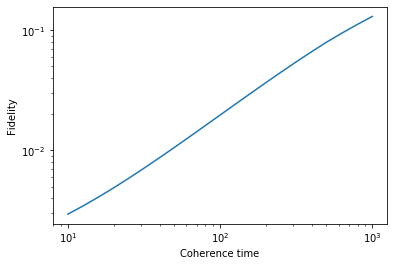

In [117]:
tau_list_inv = [1/tau for tau in tau_list]
plt.plot(tau_list_inv, infidelities)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Coherence time')
plt.ylabel('Fidelity')

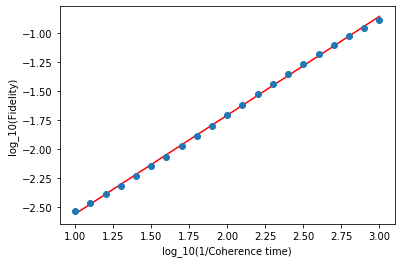

[ 0.85141655 -3.40889148]
0.005434085322310431


(array([ 0.85141655, -3.40889148]), 0.005434085322310431)

In [131]:
xdata = np.log10(tau_list_inv)
ydata = np.log10(infidelities)
FitLinear(xdata, ydata, guess = [1,1e-4])

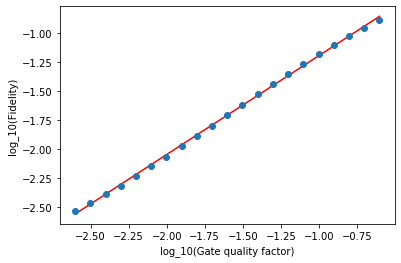

[ 0.85141655 -0.342038  ]
0.00543408504791815


(array([ 0.85141655, -0.342038  ]), 0.00543408504791815)

In [119]:
def FitLinear_2(xdata, ydata, guess):
    popt, pcov = curve_fit(linear, xdata, ydata, guess)
    plt.plot(xdata, linear(xdata, *popt), 'r-')
    plt.plot(xdata, ydata, ls='',marker='o')
#     plt.legend()
    plt.xlabel('log_10(Gate quality factor)')
    plt.ylabel('log_10(Fidelity)')
    plt.show()
    print(popt)
    print(np.sqrt(np.diag(pcov)[0]))
    return popt, np.sqrt(np.diag(pcov)[0])
gate_Q_inv = [2.5e-4/tau for tau in tau_list]
xdata = np.log10(gate_Q_inv)
ydata = np.log10(infidelities)
FitLinear_2(xdata, ydata, guess = [1,1e-4])

# Single qubit gate laser decoherence

In [140]:
tau_l_list = np.logspace(0, 4, 21)
infidelities_1q = []
for tau_l in tau_l_list:
    Omega = 1*np.pi
    H = Omega*sigmax()
    s_init = basis(2,1)
    t1_gate = 0.5/Omega*np.pi
    tlist = np.linspace(0,t1_gate,100)
    c_ops = np.sqrt(1/tau_l)*sigmaz()
    e_ops = sigmaz()
    output = mesolve(H, s_init, tlist, c_ops, e_ops)

#     plt.plot(tlist, output.expect[0])
    infidelities_1q.append(1.0-output.expect[0][-1])

In [141]:
t1_gate = 0.5/Omega*np.pi
t1_gate

0.5

Text(0, 0.5, 'Fidelity')

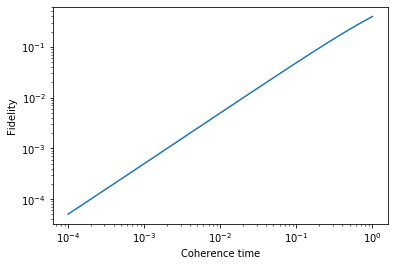

In [142]:
tau_l_list_inv = [1/tau for tau in tau_l_list]
plt.plot(tau_l_list_inv, infidelities_1q)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Coherence time')
plt.ylabel('Fidelity')

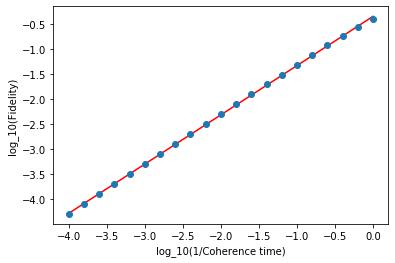

[ 0.98424758 -0.3450277 ]
0.003227086326545579


(array([ 0.98424758, -0.3450277 ]), 0.003227086326545579)

In [143]:
xdata = np.log10(tau_l_list_inv)
ydata = np.log10(infidelities_1q)
FitLinear(xdata, ydata, guess = [1,1e-4])

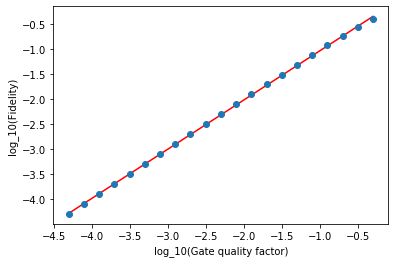

[ 0.98424758 -0.04873965]
0.0032270863468340117


(array([ 0.98424758, -0.04873965]), 0.0032270863468340117)

In [144]:
gate1_Q_inv = [t1_gate/tau for tau in tau_l_list]
xdata = np.log10(gate1_Q_inv)
ydata = np.log10(infidelities_1q)
FitLinear_2(xdata, ydata, guess = [1,1e-4])